#  Cilantro's Analytical engineering assessment



## Data Loading and Initial Exploration

This section handles loading the customer and transaction data and performing initial checks like displaying the head of the dataframes and checking their information.

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error


In [120]:
customers = pd.read_csv("customers.csv")
transactions = pd.read_csv("transactions.csv")



In [121]:
customers.head()

,user_id,app_customer_id,delivery_customer_id,website_customer_id,channels_used,acquisition_channel,age,gender
0,USER_001449,APP_001449,NaN,WEB_001449,"app,website",organic,49,M
1,USER_006288,NaN,DEL_006288,NaN,delivery aggregator,organic,43,F
2,USER_003506,APP_003506,NaN,NaN,app,email,18,F
3,USER_001189,APP_001189,DEL_001189,NaN,"app,delivery aggregator",paid_ads,41,M
4,USER_003748,NaN,NaN,WEB_003748,website,social_media,37,F


In [122]:
transactions.head()

,transaction_id,transaction_date,branch,order_channel,customer_id,total_amount
0,TXN_070981,1/1/2024,Shoubra,walk-in,NaN,92.045128
1,TXN_051127,1/1/2024,Heliopolis,walk-in,NaN,198.967497
2,TXN_001432,1/1/2024,Mohandessin,app,APP_002920,265.728640
3,TXN_032621,1/1/2024,Nasr City,website,WEB_004881,237.549924
4,TXN_024634,1/1/2024,Shoubra,app,APP_001501,252.992446


### Check DataFrame Shapes

In [123]:
print(f"Customers DataFrame shape: {customers.shape}")
print(f"Transactions DataFrame shape: {transactions.shape}")

Customers DataFrame shape: (10000, 8)
Transactions DataFrame shape: (79052, 6)


### Check for Duplicate Rows

In [124]:
print(f"Number of duplicate rows in customers: {customers.duplicated().sum()}")
print(f"Number of duplicate rows in transactions: {transactions.duplicated().sum()}")

Number of duplicate rows in customers: 0
Number of duplicate rows in transactions: 0


In [125]:
customers.info()
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   user_id               10000 non-null  object
 1   app_customer_id       4596 non-null   object
 2   delivery_customer_id  4631 non-null   object
 3   website_customer_id   4773 non-null   object
 4   channels_used         10000 non-null  object
 5   acquisition_channel   10000 non-null  object
 6   age                   10000 non-null  int64 
 7   gender                10000 non-null  object
dtypes: int64(1), object(7)
memory usage: 625.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79052 entries, 0 to 79051
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    79052 non-null  object 
 1   transaction_date  79052 non-null  object 
 2   branch            79052 non-null  object

Customers Table:There is no missing values except in the different types of customer id depending on the channel

Transactions Table:The only null values comes from customer_id as there are walk ins that order from the store directly

## Data Preprocessing

In this section, data is cleaned and prepared for analysis. This includes converting data types, handling missing values, standardizing customer IDs, and addressing inconsistencies like negative or zero transaction amounts.

In [126]:
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])


Removing prefix to make a col for joining

In [127]:
customers['user_id'] = customers['user_id'].astype(str).str.replace(r'^(USER_)', '', regex=True)
transactions['customer_id'] = transactions['customer_id'].astype(str).str.replace(r'^(APP_|DEL_|WEB_)', '', regex=True)


In [128]:
transactions['customer_id'] = transactions['customer_id'].replace('nan', np.nan)
transactions = transactions[transactions['customer_id'].notna()]


In [129]:
negatives = transactions[transactions['total_amount'] < 0]   #flag the negative values
print(f"Number of negative transactions: {len(negatives)}")

negatives.head(5)

Number of negative transactions: 290


,transaction_id,transaction_date,branch,order_channel,customer_id,total_amount
2177,TXN_046225,2024-01-10,Zamalek,delivery aggregator,003759,-177.530349
4071,TXN_072427,2024-01-19,Shoubra,website,005385,-132.746492
5545,TXN_000265,2024-01-26,Nasr City,delivery aggregator,000705,-492.942433
6246,TXN_047728,2024-01-29,Zamalek,delivery aggregator,002804,-803.847389
13858,TXN_034774,2024-03-03,Heliopolis,website,008187,-100.795716


In [130]:
zero = transactions[transactions['total_amount'] == 0]
print(f"Number of zero transactions: {len(zero)}")

zero.head(5)

Number of zero transactions: 949


,transaction_id,transaction_date,branch,order_channel,customer_id,total_amount
31518,TXN_016007,2024-06-01,Nasr City,website,003972,0.0
31530,TXN_031583,2024-06-01,New Cairo,website,000835,0.0
31533,TXN_048445,2024-06-01,Giza,website,005954,0.0
31544,TXN_048586,2024-06-01,6th October,website,008658,0.0
31555,TXN_070732,2024-06-01,Dokki,website,009681,0.0


In [131]:
transactions['total_amount'] = transactions['total_amount'].abs()  #fix them
transactions = transactions[transactions['total_amount'] != 0]

In [132]:
customers.head()

,user_id,app_customer_id,delivery_customer_id,website_customer_id,channels_used,acquisition_channel,age,gender
0,001449,APP_001449,NaN,WEB_001449,"app,website",organic,49,M
1,006288,NaN,DEL_006288,NaN,delivery aggregator,organic,43,F
2,003506,APP_003506,NaN,NaN,app,email,18,F
3,001189,APP_001189,DEL_001189,NaN,"app,delivery aggregator",paid_ads,41,M
4,003748,NaN,NaN,WEB_003748,website,social_media,37,F


In [133]:
transactions.head()

,transaction_id,transaction_date,branch,order_channel,customer_id,total_amount
2,TXN_001432,2024-01-01,Mohandessin,app,002920,265.728640
3,TXN_032621,2024-01-01,Nasr City,website,004881,237.549924
4,TXN_024634,2024-01-01,Shoubra,app,001501,252.992446
5,TXN_026419,2024-01-01,Shoubra,app,005084,226.299598
6,TXN_025633,2024-01-01,Mohandessin,delivery aggregator,009811,713.647640


in the negative case i flagged them and then removed the negative as the prices were reasonable so i assumed an honest mistake
but in the zeros case that data is corrupt or there was a sale but either way it will ruin both the CLTV and also the M in the RFM as it will bring the avg down tremendusly so they need to go

In [134]:
customers.drop(columns=[ 'app_customer_id', 'delivery_customer_id', 'website_customer_id'], inplace=True)


apply onehot encoding to channels_used to make it usable

In [135]:

customers['channels_used'] = customers['channels_used'].str.replace(' ', '')
channels_dummies = customers['channels_used'].str.get_dummies(sep=',')

# Step 4: Concatenate back to main dataframe
customers = pd.concat([customers, channels_dummies], axis=1)
customers.drop(columns=['channels_used'], inplace=True)


removed walk ins from the data as they hold no value to any metrics we are seeking to get

In [136]:
merged_df = transactions.merge(customers, left_on='customer_id', right_on='user_id', how='left')
merged_df.drop(columns=['user_id'], inplace=True)


In [137]:
merged_df.head()

,transaction_id,transaction_date,branch,order_channel,customer_id,total_amount,acquisition_channel,age,gender,app,deliveryaggregator,website
0,TXN_001432,2024-01-01,Mohandessin,app,002920,265.728640,paid_ads,50,M,1,0,1
1,TXN_032621,2024-01-01,Nasr City,website,004881,237.549924,organic,46,F,0,0,1
2,TXN_024634,2024-01-01,Shoubra,app,001501,252.992446,organic,44,F,1,1,0
3,TXN_026419,2024-01-01,Shoubra,app,005084,226.299598,social_media,22,M,1,0,0
4,TXN_025633,2024-01-01,Mohandessin,delivery aggregator,009811,713.647640,referral,28,M,0,1,0


The data represents the entire 2024 year

In [138]:
print(merged_df['transaction_date'].max())
print(merged_df['transaction_date'].min())

2024-12-31 00:00:00
2024-01-01 00:00:00


assume that the analysis starts the day after the last transaction is recorded

In [139]:
analysis_date = merged_df['transaction_date'].max() + pd.Timedelta(days=1)

## Customer Analysis (CLTV Calculation)

This section focuses on calculating key customer metrics for Customer Lifetime Value (CLTV) analysis, such as first/last transaction dates, frequency, total spent, and average order value. It also includes the calculation of Recency, Lifetime Days, and a normalized frequency for CLTV estimation.

In [140]:
cust = merged_df.groupby('customer_id').agg(
    first_tx=('transaction_date','min'),
    last_tx=('transaction_date','max'),
    frequency=('transaction_id','count'),
    total_spent=('total_amount','sum'),
    AOV=('total_amount','mean'),
    acquisition_channel=('acquisition_channel', 'first')
).reset_index()


cust['total_spent'] = cust['total_spent'].round(2)
cust['AOV'] = cust['AOV'].round(2)

In [141]:
cust.head()

,customer_id,first_tx,last_tx,frequency,total_spent,AOV,acquisition_channel
0,000001,2024-01-04,2024-12-24,268,71311.82,266.09,organic
1,000002,2024-01-01,2024-11-24,110,27263.71,247.85,social_media
2,000003,2024-02-20,2024-12-05,9,1814.01,201.56,paid_ads
3,000004,2024-02-28,2024-10-21,10,2439.75,243.97,organic
4,000005,2024-01-10,2024-12-15,11,3382.61,307.51,social_media


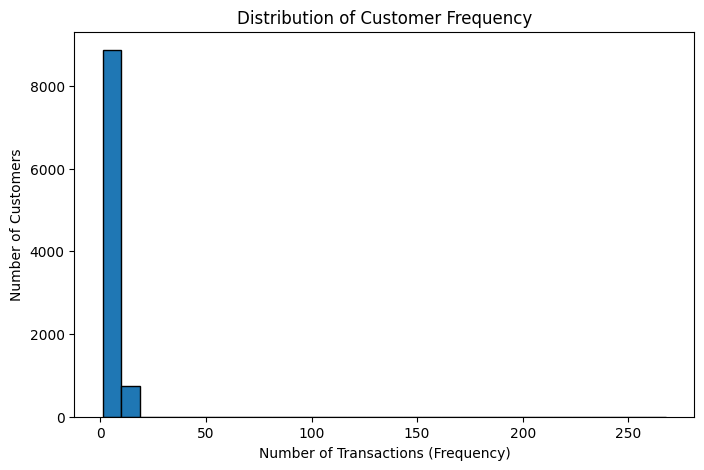

In [142]:
plt.figure(figsize=(8,5))
plt.hist(cust['frequency'], bins=30, edgecolor='black')
plt.title('Distribution of Customer Frequency')
plt.xlabel('Number of Transactions (Frequency)')
plt.ylabel('Number of Customers')
plt.show()


In [143]:
cust['frequency'].value_counts()

,count
frequency,
3,1598
2,1519
4,1406
5,1141
6,874
1,871
7,670
8,455
9,334


as we can see the data is skewed about 65% of the data visited cilantro at most 5 times during the year 2024 so we need to differentiate between them in a meaningfull way

In [144]:
cust['recency'] = (analysis_date - cust['last_tx']).dt.days
cust['lifetime_days'] = (cust['last_tx'] - cust['first_tx']).dt.days.clip(lower=1)
cust['days_since_first_purchase'] = (analysis_date - cust['first_tx']).dt.days

In [145]:
def calc_purchase_rate(row):
    if row['frequency'] < 3 or row['days_since_first_purchase'] < 7:
        return row['frequency']
    else:
        return round((row['frequency'] / row['days_since_first_purchase']) * 365)

In [146]:
cust['norm_freq'] = cust.apply(calc_purchase_rate, axis=1)
lifespan=2

cust['CLTV'] = (cust['AOV'] *cust['norm_freq']* lifespan).round(2)

In [147]:
cust['norm_freq'].value_counts()

,count
norm_freq,
2,1519
5,1061
6,1060
4,1006
1,871
7,826
8,727
3,614
9,569


Now segmenting using RFM

## RFM Segmentation

Here, customers are segmented based on Recency, Frequency, and Monetary (RFM) values. This involves defining bins and labels for each RFM component and then assigning a segment to each customer based on their scores.

In [148]:
recency_bins = [0, 7, 21, 55, 90, cust['recency'].max()]
recency_labels = [5, 4, 3, 2, 1]

freq_bins = [0, 4, 26, 52, 104, cust['norm_freq'].max()]
freq_labels = [1, 2, 3, 4, 5]

monetary_bins = [0, 60, 120, 180, 250, cust['AOV'].max()]
monetary_labels = [1, 2, 3, 4, 5]


In [149]:
cust['r_score'] = pd.cut(cust['recency'], bins=recency_bins, labels=recency_labels, include_lowest=True).astype(int)
cust['f_score'] = pd.cut(cust['norm_freq'], bins=freq_bins, labels=freq_labels, include_lowest=True).astype(int)
cust['m_score'] = pd.cut(cust['AOV'], bins=monetary_bins, labels=monetary_labels, include_lowest=True).astype(int)

cust['RFM_Score'] = cust['r_score'] + cust['f_score'] + cust['m_score']


In [150]:
def segment_coffee_shop(row):
    if row['r_score'] >= 4 and row['f_score'] >= 4 and row['m_score']>=3:
        return 'Champions'

    elif row['r_score'] >= 3 and row['f_score'] >= 3 and row['m_score']>=2:
        return 'Loyal Regulars'

    elif row['r_score'] >= 4 and row['f_score'] <= 2:
        return 'Potential regulars'

    elif row['r_score'] >= 2 and row['f_score'] >= 2:
        return 'At Risk'

    else:
        return 'Inactive'


cust['segment'] = cust.apply(segment_coffee_shop, axis=1)

cust.head()


,customer_id,first_tx,last_tx,frequency,total_spent,AOV,acquisition_channel,recency,lifetime_days,days_since_first_purchase,norm_freq,CLTV,r_score,f_score,m_score,RFM_Score,segment
0,000001,2024-01-04,2024-12-24,268,71311.82,266.09,organic,8,355,363,269,143156.42,4,5,5,14,Champions
1,000002,2024-01-01,2024-11-24,110,27263.71,247.85,social_media,38,328,366,110,54527.00,3,5,4,12,Loyal Regulars
2,000003,2024-02-20,2024-12-05,9,1814.01,201.56,paid_ads,27,289,316,10,4031.20,3,2,4,9,At Risk
3,000004,2024-02-28,2024-10-21,10,2439.75,243.97,organic,72,236,308,12,5855.28,2,2,4,8,At Risk
4,000005,2024-01-10,2024-12-15,11,3382.61,307.51,social_media,17,340,357,11,6765.22,4,2,5,11,Potential regulars


In [151]:
cust['segment'].value_counts()


,count
segment,
Inactive,4294
At Risk,2873
Potential regulars,2450
Loyal Regulars,7
Champions,1


# CLTV Predictive model

In [152]:
predictive_df = cust.copy()

encoder = LabelEncoder()
predictive_df['acquisition_channel_encoded'] = encoder.fit_transform(predictive_df['acquisition_channel'].astype(str))
predictive_df['segmenttt'] = encoder.fit_transform(predictive_df['segment'].astype(str))


In [153]:
X = predictive_df[['recency', 'norm_freq', 'AOV', 'lifetime_days', 'acquisition_channel_encoded','segmenttt']]
y = predictive_df['CLTV']/2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

In [154]:

model = RandomForestRegressor(random_state=42, n_estimators=400)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Model Performance:")
print(f"R² Score: {r2:.3f}")
print(f"MAE: {mae:.2f}")


Model Performance:
R² Score: 0.647
MAE: 32.13


In [155]:
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=7,
    subsample=0.7,
    random_state=10,
    reg_lambda=1
)

In [156]:
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"XGBoost Model Performance:")
print(f"R² Score: {r2_xgb:.3f}")
print(f"MAE: {mae_xgb:.2f}")

XGBoost Model Performance:
R² Score: 0.744
MAE: 32.25


## Output Tables

This final section generates the required output tables, including the user-level data with CLTV and segment information, a summary of segments, and a summary by acquisition channel. These tables are also saved to CSV files.

In [157]:
user_level = cust[['customer_id', 'recency', 'frequency', 'total_spent', 'CLTV', 'segment', 'lifetime_days']].copy()
user_level = user_level.rename(columns={'total_spent': 'monetary_value'})
user_level['customer_id'] = 'USER_' + user_level['customer_id'].astype(str)
user_level.head()


,customer_id,recency,frequency,monetary_value,CLTV,segment,lifetime_days
0,USER_000001,8,268,71311.82,143156.42,Champions,355
1,USER_000002,38,110,27263.71,54527.00,Loyal Regulars,328
2,USER_000003,27,9,1814.01,4031.20,At Risk,289
3,USER_000004,72,10,2439.75,5855.28,At Risk,236
4,USER_000005,17,11,3382.61,6765.22,Potential regulars,340


In [158]:
user_level.to_csv('user_level.csv', index=False)


In [159]:
segment_summary = cust.groupby('segment').agg(
    num_users=('customer_id', 'count'),
    avg_frequency=('frequency', 'mean'),
    avg_monetary=('total_spent', 'mean'),
    avg_CLTV=('CLTV', 'mean'),
    avg_lifetime_days=('lifetime_days', 'mean')
).reset_index()

segment_summary.head()



,segment,num_users,avg_frequency,avg_monetary,avg_CLTV,avg_lifetime_days
0,At Risk,2873,6.559694,1748.963536,4326.802074,248.751131
1,Champions,1,268.000000,71311.820000,143156.420000,355.000000
2,Inactive,4294,2.930834,760.041619,1690.766651,139.037028
3,Loyal Regulars,7,19.428571,5122.732857,23803.862857,79.571429
4,Potential regulars,2450,5.742857,1559.931853,3913.003771,267.368571


In [166]:
segment_summary.to_csv('segment_summary.csv', index=False)

In [161]:
acq_summary = (
    cust.groupby('acquisition_channel')
    .agg(
        num_users=('customer_id', 'nunique'),
        avg_frequency=('frequency', 'mean'),
        avg_monetary=('total_spent', 'mean'),
        avg_CLTV=('CLTV', 'mean'),
        avg_lifetime_days=('lifetime_days', 'mean')
    )
    .reset_index()
)
acq_summary.head()

,acquisition_channel,num_users,avg_frequency,avg_monetary,avg_CLTV,avg_lifetime_days
0,email,1880,4.843617,1250.135160,3019.836851,209.844681
1,organic,1960,5.027551,1284.720383,3086.711796,209.362245
2,paid_ads,1863,4.064949,1048.536957,2507.746699,180.031669
3,referral,1007,4.987090,1677.596455,4205.431202,221.591857
4,social_media,2915,4.922813,1271.466521,3071.577132,207.290566


In [162]:
acq_summary.to_csv('acquisition_channel_summary.csv', index=False)


In [163]:
cust.head()

,customer_id,first_tx,last_tx,frequency,total_spent,AOV,acquisition_channel,recency,lifetime_days,days_since_first_purchase,norm_freq,CLTV,r_score,f_score,m_score,RFM_Score,segment
0,000001,2024-01-04,2024-12-24,268,71311.82,266.09,organic,8,355,363,269,143156.42,4,5,5,14,Champions
1,000002,2024-01-01,2024-11-24,110,27263.71,247.85,social_media,38,328,366,110,54527.00,3,5,4,12,Loyal Regulars
2,000003,2024-02-20,2024-12-05,9,1814.01,201.56,paid_ads,27,289,316,10,4031.20,3,2,4,9,At Risk
3,000004,2024-02-28,2024-10-21,10,2439.75,243.97,organic,72,236,308,12,5855.28,2,2,4,8,At Risk
4,000005,2024-01-10,2024-12-15,11,3382.61,307.51,social_media,17,340,357,11,6765.22,4,2,5,11,Potential regulars


In [164]:
predictive_output = X_test.copy()
predictive_output['customer_id'] = predictive_df.loc[X_test.index, 'customer_id']
predictive_output['predicted_cltv'] = y_pred_xgb
predictive_output['horizon_months'] = 12  # specify horizon
predictive_output=predictive_output[['customer_id', 'predicted_cltv', 'horizon_months']].copy()
predictive_output.head()



,customer_id,predicted_cltv,horizon_months
6353,006541,1397.421997,12
7069,007305,907.761902,12
781,000782,1606.713135,12
8108,008400,418.518951,12
4867,004974,506.482605,12


In [167]:
predictive_output.to_csv('predictive_output.csv', index=False)